In [1]:
import pandas as pd
%matplotlib  widget
import matplotlib.pyplot as plt

import numpy as np
import scipy as scp
from scipy.signal import butter, filtfilt
# To import custom scripts like the one below ---> in the electricalsync main directory:   pip install -e .
import src.utilities as utils

Variables

In [2]:
path = "/home/pablo/Escritorio" #Path to the file
file = "/test.csv" #File
fullpath = path + file
h0 = "TIME" #Header of column 0: Time
h1 = "PD1" #Header of column 1: Left Electrode
h2 = "PD2" #Header of column 2: Right Electrode
h3 = "EXTRA1" #Header of column 3: Left Extracellular
h4 = "EXTRA2" #Header of column 4: Right Extracellular

Discard = False #Wether to discard spikes when they are missing in the other neuron
Interspike_max_missing = 200 #ms*10e-1
Interburst = 1000 #ms*10e-1
Template_df = pd.DataFrame()
Highthresh = 0.35
Lowthresh = 0.3 #not used yet
CommonStandard_df = pd.DataFrame()

portion = None#2000000 #Portion / rows of the record to use (1 = 0,1ms; 10000 = 1s; 100000 = 10s; 1000000 = 100s; 10000000 = 1000s)


Read File

In [3]:
CommonStandard_df = pd.read_csv(fullpath, delimiter = " ", names=(h0, h3, h4, h1, h2), usecols=(0,1,2,3,4), skiprows=None, nrows=portion)[[h0, h1, h2, h3, h4]]
storage = path+"/CS.csv"
# CommonStandard_df.to_csv (storage, index = False, sep=' ')

Filter Signal && Simple slope spiking method

In [4]:
PD1 = CommonStandard_df[h1]
lowfiltered1 = utils.lowpass_filter(PD1, 1000, 10000)#Filtro para ruido
highfiltered1 = utils.highpass_filter(lowfiltered1, 10, 10000)

PD2 = CommonStandard_df[h2]
lowfiltered2 = utils.lowpass_filter(PD2, 1000, 10000)
highfiltered2 = utils.highpass_filter(lowfiltered2, 10, 10000)



Spike Detection

In [5]:
spikes_beg1, spikes_end1 = utils.detect_single(highfiltered1, Highthresh)
spikes_beg2, spikes_end2 = utils.detect_single(highfiltered2, Highthresh)

In [6]:
spikes_max1 = utils.get_spikes_max(PD1, spikes_beg1, spikes_end1)
spikes_max2 = utils.get_spikes_max(PD2, spikes_beg2, spikes_end2)

In [7]:
spikes_mids1 = utils.get_spikes_middle(spikes_beg1, spikes_end1)
spikes_mids2 = utils.get_spikes_middle(spikes_beg2, spikes_end2)

Relocate spikes in one neuron when the other misses spikes

In [8]:
spikes_beg1, spikes_end1, spikes_max1, spikes_mids1, spikes_beg2, spikes_end2, spikes_max2, spikes_mids2 = utils.relocate_spikes(
	Interspike_max_missing, spikes_beg1, spikes_end1, spikes_max1, spikes_mids1, spikes_beg2, spikes_end2, spikes_max2, spikes_mids2)

Burst Detection

In [9]:
burst_num = utils.detect_burst_number(spikes_beg1, spikes_beg2)
spike_num = utils.detect_spike_number(burst_num)
event_index = list(range(1,len(spike_num)+1))

#IMPORTANTE!! Si se pierde el último spike justo en el último elemento del array quitar ese último elemento y ya
if len(spikes_beg2) > len(spikes_beg1):
	spikes_beg2.pop()
	spikes_end2.pop()
	spikes_max2.pop()
	spikes_mids2.pop()
	burst_num.pop()
	spike_num.pop()
	event_index.pop()

elif len(spikes_beg1) > len(spikes_beg2):
	spikes_beg1.pop()
	spikes_end1.pop()
	spikes_max1.pop()
	spikes_mids1.pop()
	burst_num.pop()
	spike_num.pop()
	event_index.pop()
#IMPORTANTE!!

print(len(spikes_beg1), len(spikes_end1), len(spikes_max1), len(spikes_mids1), len(spikes_beg2), 
	len(spikes_end2), len(spikes_max2), len(spikes_mids2), len(burst_num), len(spike_num))

35831 35831 35831 35831 35831 35831 35831 35831 35831 35831


Plot Filtered Signal with detected spikes

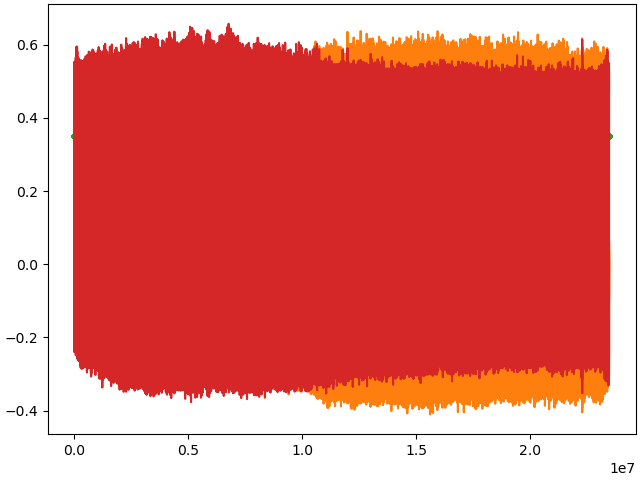

In [13]:
fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(spikes_beg1, np.zeros_like(spikes_beg1)+Highthresh, '.')
# ax.plot(spikes_end1, np.zeros_like(spikes_end1)+Highthresh, '.')
# ax.plot(spikes_max1, np.zeros_like(spikes_max1)+Highthresh, '.')
ax.plot(spikes_mids1, np.zeros_like(spikes_mids1)+Highthresh, '.')
ax.plot(highfiltered1)

# ax.plot(spikes_beg2, np.zeros_like(spikes_beg2)+Highthresh, '.')
# ax.plot(spikes_end2, np.zeros_like(spikes_end2)+Highthresh, '.')
# ax.plot(spikes_max2, np.zeros_like(spikes_max2)+Highthresh, '.')
ax.plot(spikes_mids2, np.zeros_like(spikes_mids2)+Highthresh, '.')
ax.plot(highfiltered2)
plt.show()

Template

In [11]:

Template_df = pd.DataFrame({'Event': event_index, 'Burst_Num': burst_num, 'Spike_Num': spike_num, 'PD1_Beg': spikes_beg1, 'PD1_End': spikes_end1, 
	'PD1_Max': spikes_max1, 'PD1_Mids': spikes_mids1, 'PD2_Beg': spikes_beg2, 'PD2_End': spikes_end2, 'PD2_Max': spikes_max2, 'PD2_Mids': spikes_mids2})

Template_df.to_csv((path+"/Template.csv"), index = False, sep=' ')

Raster plot

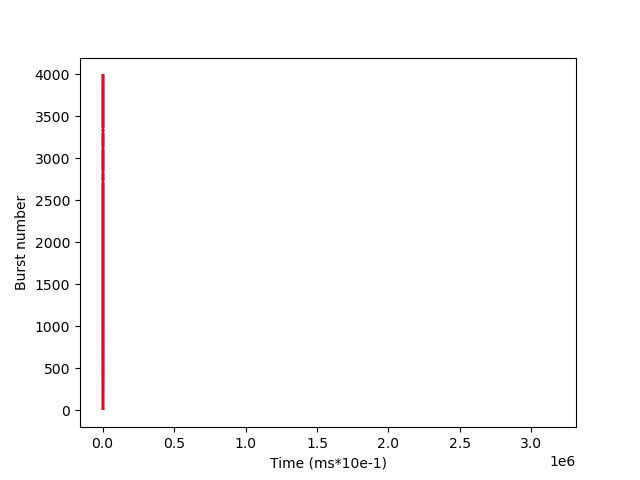

In [12]:
raster_list_PD1 = utils.raster_plot(spike_num, spikes_mids1)
raster_list_PD2 = utils.raster_plot(spike_num, spikes_mids2)

plt.close()# To close the previous plot
plt.eventplot(raster_list_PD1, linestyles = ':', colors = "b")
plt.eventplot(raster_list_PD2, linestyles = ':', colors = "r") 
plt.xlabel("Time (ms*10e-1)")
plt.ylabel("Burst number")
plt.show()



Intervalos

Raster solo afecta a los tiempos de los potenciales

Medidas técnicas a analizar:

- Incluir adicional al ráster todos los intervalos/duración de ráfaga etc en una figura suplementaria
- Superposición de ráfagas (película)
- Relacionar ráster con las secuencias (a mayor sync/ duración de ráfaga que pasa con los intervalos: periodo instantáneo e invariante)
-
-
